In [5]:
# This is a Task Description on the steps we actually need to achieve:
"""    
Model Selection:
-   We should start by exploring different kernel functions and their hyperparameters for Gaussian Process (GP) regression. 
    Basically we need to experiment with various kernel functions.
-   According to the assignment we should consider using the marginal likelihood (also known as the evidence) to 
    evaluate the goodness of fit for different kernels and hyperparameters. We need to choose the kernel that 
    maximizes the marginal likelihood.        
    
Large-Scale Learning:
-   Since GP inference can become computationally expensive for large datasets, you should explore strategies to mitigate this issue.
    One option is to consider undersampling, where we randomly select a subset of our data points for model training.       
-   Another option is kernel low-rank approximations, such as the Nyström method or random Fourier features. 

Asymmetric Cost:
-   Also we need to develop a custom decision rule that takes into account the specialized cost function provided. Since the city wants 
    to avoid underestimating pollution concentration, we'll need to assign different costs to false positives and false negatives.
-   We should also consider using techniques like threshold tuning to optimize our model's predictions based on the asymmetric 
    cost function. We could also explore the use of quantile regression or asymmetric loss functions to explicitly address the 
    city's concerns about underestimation.

Validation and Testing:
-   Ensure you have a robust validation and testing framework to evaluate your model's performance. 
    Since it was discussed in the lecture we should consider using techniques like cross-validation.
"""

'TESt\n '

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor

# Read the CSV file
area_data = pd.read_csv("train_x.csv")
concentration_data = pd.read_csv("train_y.csv")

area_data.head()
concentration_data.head()

# Split the data
# Used a small sample set to test and run the Gaussian Process
X_train, X_test, y_train, y_test = train_test_split(area_data[['lon', 'lat']], concentration_data['pm25'], test_size=0.95, random_state=0)

# Here I want to split the test Data set again:
X_test_1, X_test_2, y_test_1, y_test_2 = train_test_split(X_test, y_test, test_size=0.95, random_state=0)

# RBF Kernel and Gaussian Process with arbitrary used Hyperparameter
# Note: I used the RBF Kernel but basically we have to test different kernels to understand the data!
# After we found the right Kernel we should find ideal Hyperparameter values!
# The kernel that fits best gives as inisghts bout the data, in terms of periodicity, or other relationships!
kernel = 1.0 * RBF(length_scale=0.5)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_model.fit(X_train, y_train)

# Our goal is to maximize the marignal likelihood
log_likelihood = gp_model.log_marginal_likelihood()

# Testing Model with a small set!
y_pred, sigma = gp_model.predict(X_test_1, return_std=True)

# Analysis of the Gaussian Process

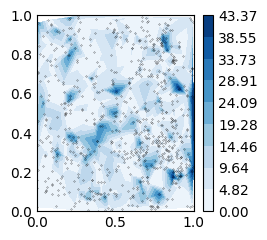

In [23]:
error = abs(y_pred - y_test_1)

# Plot: 2D Representation!

levels = np.linspace(error.min(), error.max(), 10)

fig, ax = plt.subplots()
ax.plot(X_test_1['lat'], X_test_1['lon'], 'o', markersize=0.2, color='black')
tgf = ax.tricontourf(X_test_1['lat'], X_test_1['lon'], error, levels=levels)
ax.set(xlim=(0, 1), ylim=(0, 1))
fig.colorbar(tgf)
plt.show()



# Graphical Analysis for further Clustering

15189


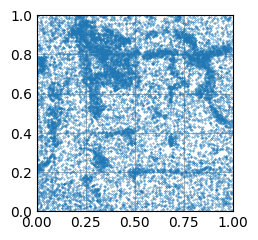

In [20]:

plt.style.use('_mpl-gallery')

# Make data
X = area_data.loc[:,'lon']
Y = area_data.loc[:,'lat']
Z = concentration_data.loc[:,'pm25']

print(len(X))

Area = area_data.loc[:,'residential']

# Plot 3D Representation!
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(X, Y, Z)
# ax.set(xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])
# plt.show()


# Plot: 2D Representation!
levels = np.linspace(Z.min(), Z.max(), 7)

# fig, ax = plt.subplots()
# ax.plot(X, Y, 'o', markersize=0.2, color='black')
# ax.tricontourf(X, Y, Area, levels=levels)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# fig, ax = plt.subplots(2, 2)
# ax.plot(X, Y, 'o', markersize=0.2, color='black')
# ax.tricontourf(X, Y, Z, levels=levels)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# Plot: 2D without the contour!
fig, ax = plt.subplots()
ax.scatter(X, Y, s = 0.1)
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

# Visualization of the Test Data

In [46]:
Input_test = pd.read_csv("test_x.csv")
X_test_tot = Input_test.loc[:,'lon']
Y_test_tot = Input_test.loc[:,'lat']
Res_test = Input_test.loc[:,'residential']

idx_res_1 = np.nonzero(Res_test)[0]
print("Res = 0:", len(idx_res_1))
print("Res = 0:", len(Res_test)-len(idx_res_1))

# Plot: 2D without the contour!
# fig, ax = plt.subplots()
# ax.scatter(X_test_tot, Y_test_tot, s = 0.1)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# plt.show()

# Clustering Approach:

store_idx = []
radius = 0.01
for i in range(len(X_test_tot)):
    Dxx = abs(area_data.loc[:,'lat'] - X_test_tot[i]) ** 2
    Dyy = abs(area_data.loc[:,'lon'] - Y_test_tot[i]) ** 2
    Dist = np.sqrt(Dxx + Dyy)

    idx_i = np.where(Dist < radius)[0]
    new_indices = np.setdiff1d(idx_i, store_idx)
    store_idx.extend(new_indices)

print(len(store_idx))


Res = 0: 1464
Res = 0: 1847
7620


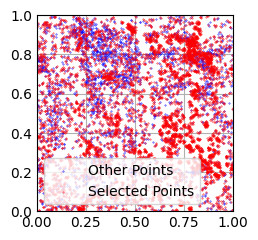

[{0: array([-1, -1, -1, ..., -1, -1, -1]), 1: array([-1, -1, -1, ..., -1, -1, -1]), 2: array([-1, -1, -1, ..., -1, -1, -1]), 3: array([-1, -1, -1, ..., -1, -1, -1]), 4: array([-1, -1, -1, ..., -1, -1, -1]), 5: array([-1, -1, -1, ..., -1, -1, -1]), 6: array([-1, -1, -1, ..., -1, -1, -1]), 7: array([-1, -1, -1, ..., -1, -1, -1]), 8: array([-1, -1, -1, ..., -1, -1, -1]), 9: array([-1, -1, -1, ..., -1, -1, -1]), 10: array([-1, -1, -1, ..., -1, -1, -1]), 11: array([-1, -1, -1, ..., -1, -1, -1]), 12: array([-1, -1, -1, ..., -1, -1, -1]), 13: array([-1, -1, -1, ..., -1, -1, -1]), 14: array([-1, -1, -1, ..., -1, -1, -1]), 15: array([-1, -1, -1, ..., -1, -1, -1]), 16: array([-1, -1, -1, ..., -1, -1, -1]), 17: array([-1, -1, -1, ..., -1, -1, -1]), 18: array([-1, -1, -1, ..., -1, -1, -1]), 19: array([-1, -1, -1, ..., -1, -1, -1]), 20: array([-1, -1, -1, ..., -1, -1, -1]), 21: array([-1, -1, -1, ..., -1, -1, -1]), 22: array([-1, -1, -1, ..., -1, -1, -1]), 23: array([-1, -1, -1, ..., -1, -1, -1]), 

In [60]:
fig, ax = plt.subplots()
ax.scatter(X_test_tot, Y_test_tot, s=0.1, color='blue', label='Other Points')
ax.scatter(area_data.loc[store_idx,'lat'], area_data.loc[store_idx, 'lon'], s=0.1, color='red', label='Selected Points')
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.legend() 
plt.show()

from sklearn.cluster import DBSCAN


# Set DBSCAN parameters
eps = 0.001  # Radius for DBSCAN
min_samples = 5  # Minimum number of samples in a cluster

cluster_labels = {}

for i in range(len(X_test_tot)):
    X_centered = np.column_stack((area_data.loc[store_idx,'lat'] - X_test_tot[i], area_data.loc[store_idx,'lon']- Y_test_tot[i]))

    # Fit DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_centered)

    # Get the cluster labels (each label corresponds to a train data point)
    labels = db.labels_

    # Store the cluster labels for this test point
    cluster_labels[i] = labels

print(np.unique(cluster_labels))


In [67]:
idx_1 = np.where(cluster_labels[100] != -1)[0]

idx_cluster = []

for i in range(len(cluster_labels)):
    idx_tot = np.where(cluster_labels[100] != -1)[0]
    if len(idx_tot) > 0:
        new_indices = np.setdiff1d(idx_i, idx_tot)
        idx_cluster.extend(new_indices)

print(len(idx_cluster))
        

[]
